In [5]:
## for storing the dataset
# from dataset import create_small_dataset
# !mkdir ./data/sm0llest
# create_small_dataset("./data/train/", 100, "./data/sm0llest/")
# import wandb
# wandb.init(project="wall_jepa")
# artifact = wandb.Artifact("sm0llest", type="dataset")
# artifact.add_dir("./data/sm0llest")
# wandb.log_artifact(artifact)

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from dataset import create_wall_dataloader
dl = create_wall_dataloader("../data/sm0ll/")

Loading data from ../data/sm0ll/ ...
Dataset size: 10000
States shape: (10000, 17, 2, 65, 65)
Actions shape: (10000, 16, 2)


In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def debug_trajectory_visualization(dl, index=1, debug=False):
    print(f"Debugging trajectory visualization for index {index}")
    
    # Get the sample
    sample = dl.dataset[index]
    
    print("Sample structure:")
    print(f"States shape: {sample.states.shape}")
    print(f"Actions shape: {sample.actions.shape}")
    print(f"Locations shape: {sample.locations.shape}")
    
    # Check if states and actions have the same number of time steps
    if sample.states.shape[0] != sample.actions.shape[0]:
        print("WARNING: Number of time steps in states and actions do not match!")
        print(f"States time steps: {sample.states.shape[0]}")
        print(f"Actions time steps: {sample.actions.shape[0]}")
    
    # Print some statistics
    print("\nStatistics:")
    print(f"States min: {sample.states.min().item():.4f}, max: {sample.states.max().item():.4f}")
    print(f"Actions min: {sample.actions.min().item():.4f}, max: {sample.actions.max().item():.4f}")
    
    # Move tensors to CPU and convert to numpy arrays
    states_np = sample.states.cpu().numpy()
    actions_np = sample.actions.cpu().numpy()


    if debug:
        for i in range(states_np.shape[0]):
            fig, ax = plt.subplots(figsize=(4, 4))
            ax.imshow(states_np[i, 0], cmap='gray')
            ax.imshow(states_np[i, 1], cmap='jet', alpha=0.5)
            ax.set_title(f"State {i}")
            plt.show()
            
            if i < actions_np.shape[0]:
                print(f"Action {i}: {actions_np[i]}")
            else:
                print("No action (final state)")
            print("\n" + "-"*50 + "\n")
        
        return None
    
    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle("Trajectory Visualization")
    
    # Initialize the plots
    wall_img = ax1.imshow(states_np[0, 0], cmap='gray')
    agent_img = ax1.imshow(states_np[0, 1], cmap='jet', alpha=0.5)
    ax1.set_title("Agent's View")
    
    action_lines = [ax2.plot([], [], label=f'Action {i+1}')[0] for i in range(actions_np.shape[1])]
    ax2.set_xlim(0, len(actions_np) - 1)
    ax2.set_ylim(actions_np.min(), actions_np.max())
    ax2.set_title("Actions")
    ax2.legend()
    
    # Animation update function
    def update(frame):
        wall_img.set_array(states_np[frame, 0])
        agent_img.set_array(states_np[frame, 1])
        
        for i, line in enumerate(action_lines):
            line.set_data(range(frame + 1), actions_np[:frame + 1, i])
        
        return [wall_img, agent_img] + action_lines
    
    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=min(states_np.shape[0], actions_np.shape[0]),
                                   interval=200, blit=True)
    
    plt.close(fig)  # Prevent the initial figure from being displayed
    return anim

# Use the function like this:
anim = debug_trajectory_visualization(dl)
HTML(anim.to_jshtml())

Debugging trajectory visualization for index 1


/data/DL_24/dataset.py:96: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  states = torch.from_numpy(self.states[i]).float().to(self.device)


Sample structure:
States shape: torch.Size([17, 2, 65, 65])
Actions shape: torch.Size([16, 2])
Locations shape: torch.Size([0])
States time steps: 17
Actions time steps: 16

Statistics:
States min: 0.0000, max: 0.0941
Actions min: -0.7042, max: 1.3499


Debugging trajectory visualization for index 1
Sample structure:
States shape: torch.Size([17, 2, 65, 65])
Actions shape: torch.Size([16, 2])
Locations shape: torch.Size([0])
States time steps: 17
Actions time steps: 16

Statistics:
States min: 0.0000, max: 0.0942
Actions min: -1.6864, max: 1.6277


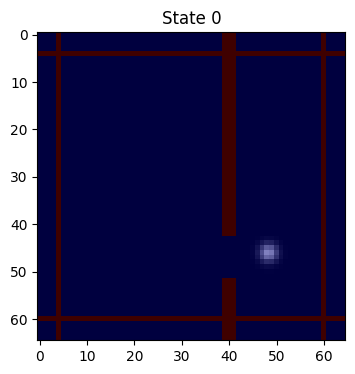

Action 0: [-1.686392  -0.3767559]

--------------------------------------------------



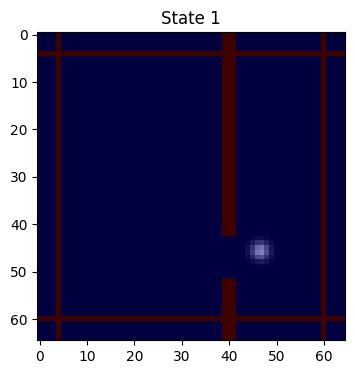

Action 1: [-0.5680665   0.16482288]

--------------------------------------------------



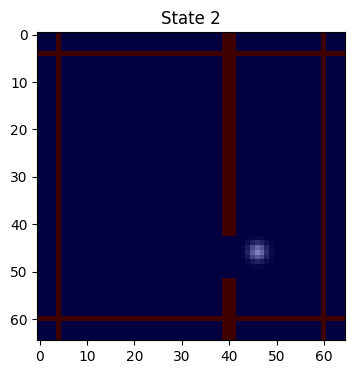

Action 2: [-0.24732384  0.02939416]

--------------------------------------------------



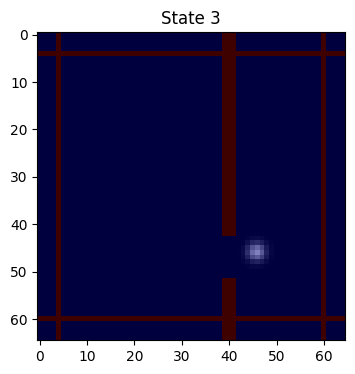

Action 3: [-1.093949    0.16826916]

--------------------------------------------------



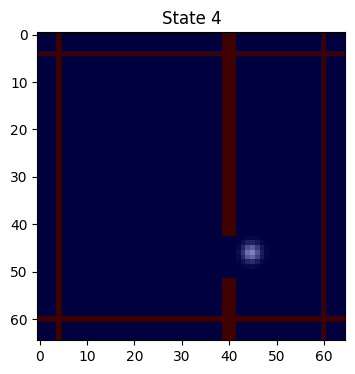

Action 4: [-0.87830323  0.4708313 ]

--------------------------------------------------



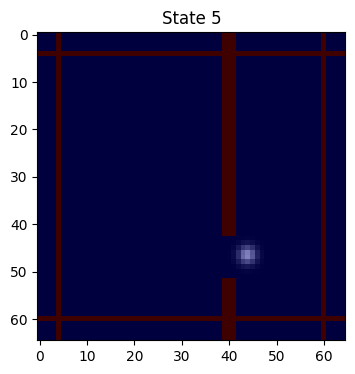

Action 5: [-1.1763254   0.15208994]

--------------------------------------------------



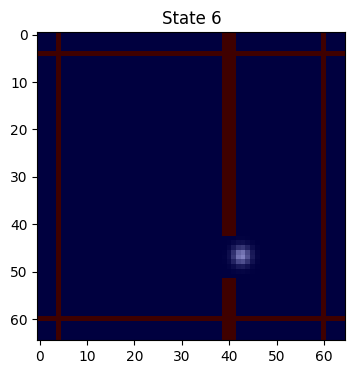

Action 6: [-0.7529415  -0.09688248]

--------------------------------------------------



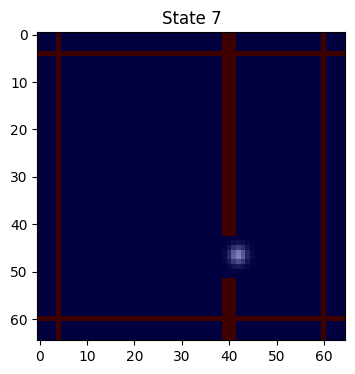

Action 7: [-0.98386157 -0.09757787]

--------------------------------------------------



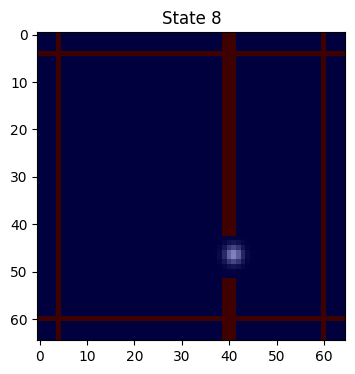

Action 8: [-0.60751474  0.30309436]

--------------------------------------------------



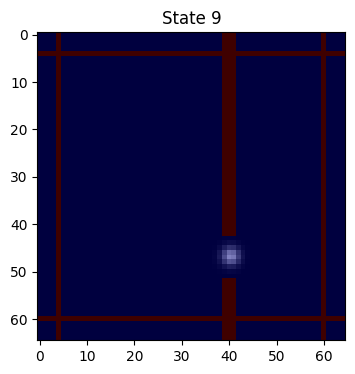

Action 9: [-0.70486116  0.55141664]

--------------------------------------------------



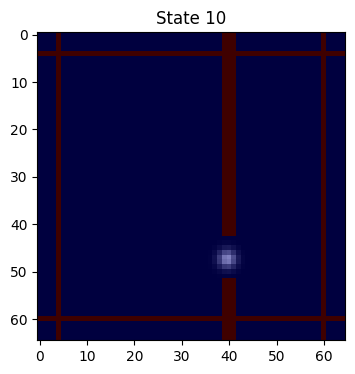

Action 10: [-0.76688117  1.6276654 ]

--------------------------------------------------



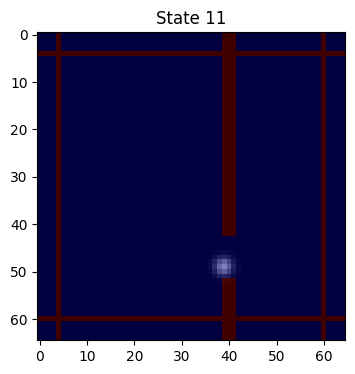

Action 11: [0.21143144 1.1943645 ]

--------------------------------------------------



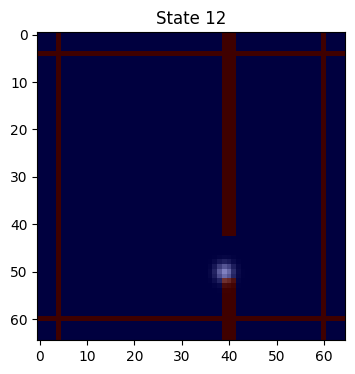

Action 12: [0.4399782 0.7403319]

--------------------------------------------------



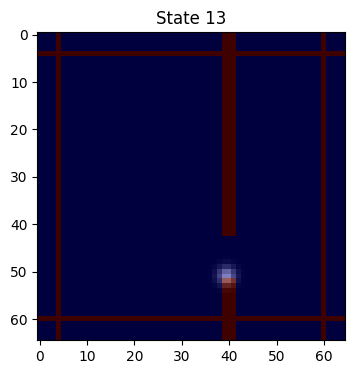

Action 13: [0.6310008 1.1417454]

--------------------------------------------------



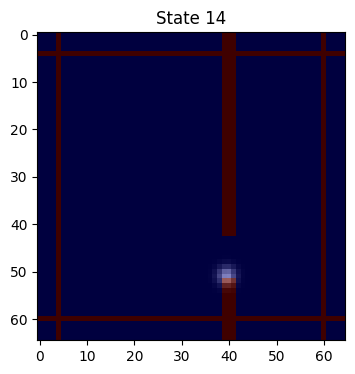

Action 14: [0.31716084 0.34917063]

--------------------------------------------------



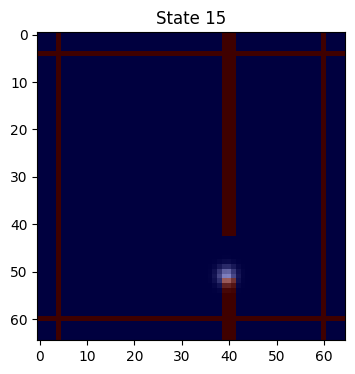

Action 15: [0.5745389 0.4427163]

--------------------------------------------------



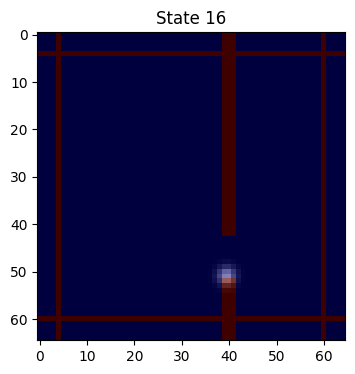

No action (final state)

--------------------------------------------------



In [11]:
debug_trajectory_visualization(dl,1, debug=True)

In [6]:
from dataset import apply_augmentations
def visualize_augmentation_comparison(dl, index=1):
    """Visualize original and augmented version of a trajectory side by side"""
    print(f"Visualizing original and augmented trajectory for index {index}")
    
    # Get original sample
    sample = dl.dataset[index]
    
    # Get states and actions as numpy arrays
    states_np = sample.states.cpu().numpy()
    actions_np = sample.actions.cpu().numpy()
    
    # Create augmented version
    aug_states, aug_actions = apply_augmentations(states_np, actions_np, 1, 0)
    
    # Create figure with two sets of subplots
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    
    fig.suptitle("Original vs Augmented Trajectory")
    
    # Initialize original plots
    wall_img = ax1.imshow(states_np[0, 0], cmap='gray')
    agent_img = ax1.imshow(states_np[0, 1], cmap='jet', alpha=0.5)
    ax1.set_title("Original Agent's View")
    
    action_lines = [ax2.plot([], [], label=f'Action {i+1}')[0] for i in range(actions_np.shape[1])]
    ax2.set_xlim(0, len(actions_np) - 1)
    ax2.set_ylim(actions_np.min(), actions_np.max())
    ax2.set_title("Original Actions")
    ax2.legend()
    
    # Initialize augmented plots
    aug_wall_img = ax3.imshow(aug_states[0, 0], cmap='gray')
    aug_agent_img = ax3.imshow(aug_states[0, 1], cmap='jet', alpha=0.5)
    ax3.set_title("Augmented Agent's View")
    
    aug_action_lines = [ax4.plot([], [], label=f'Action {i+1}')[0] for i in range(aug_actions.shape[1])]
    ax4.set_xlim(0, len(aug_actions) - 1)
    ax4.set_ylim(aug_actions.min(), aug_actions.max())
    ax4.set_title("Augmented Actions")
    ax4.legend()
    
    def update(frame):
        # Update original plots
        wall_img.set_array(states_np[frame, 0])
        agent_img.set_array(states_np[frame, 1])
        
        for i, line in enumerate(action_lines):
            line.set_data(range(frame + 1), actions_np[:frame + 1, i])
            
        # Update augmented plots    
        aug_wall_img.set_array(aug_states[frame, 0])
        aug_agent_img.set_array(aug_states[frame, 1])
        
        for i, line in enumerate(aug_action_lines):
            line.set_data(range(frame + 1), aug_actions[:frame + 1, i])
        
        return [wall_img, agent_img] + action_lines + [aug_wall_img, aug_agent_img] + aug_action_lines
    
    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=min(states_np.shape[0], actions_np.shape[0]),
                                 interval=200, blit=True)
    
    plt.close(fig)
    return anim

# Use the function like this:
anim = visualize_augmentation_comparison(dl,5)
HTML(anim.to_jshtml())


Visualizing original and augmented trajectory for index 5


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Arrow
from dataset import apply_augmentations

def visualize_augmentation_comparison(dl, index=1):
    """Visualize original and augmented version of a trajectory side by side"""
    print(f"Visualizing original and augmented trajectory for index {index}")
    
    # Get original sample
    sample = dl.dataset[index]
    
    # Get states and actions as numpy arrays
    states_np = sample.states.cpu().numpy()
    actions_np = sample.actions.cpu().numpy()
    
    # Create augmented version
    aug_states, aug_actions = apply_augmentations(states_np, actions_np, 0.5, 0)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    fig.suptitle("Original vs Augmented Trajectory")
    
    # Initialize original plot
    wall_img = ax1.imshow(states_np[0, 1], cmap='gray', extent=[0, 64, 64, 0])
    agent_img = ax1.imshow(states_np[0, 0], cmap='jet', alpha=0.5, extent=[0, 64, 64, 0])
    ax1.set_title("Original Agent's View")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    
    # Initialize augmented plot
    aug_wall_img = ax2.imshow(aug_states[0, 1], cmap='gray', extent=[0, 64, 64, 0])
    aug_agent_img = ax2.imshow(aug_states[0, 0], cmap='jet', alpha=0.5, extent=[0, 64, 64, 0])
    ax2.set_title("Augmented Agent's View")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    
    # Initialize action arrows
    action_arrow = ax1.add_patch(Arrow(0, 0, 0, 0, width=0.5, color='r'))
    aug_action_arrow = ax2.add_patch(Arrow(0, 0, 0, 0, width=0.5, color='r'))
    
    def update(frame):
        nonlocal action_arrow, aug_action_arrow
        
        # Update original plot
        wall_img.set_array(states_np[frame, 1])
        agent_img.set_array(states_np[frame, 0])
        
        # Update augmented plot
        aug_wall_img.set_array(aug_states[frame, 1])
        aug_agent_img.set_array(aug_states[frame, 0])
        
        # Update action arrows
        if frame < len(actions_np):
            agent_pos = np.unravel_index(states_np[frame, 0].argmax(), states_np[frame, 0].shape)
            action_arrow.remove()
            action_arrow = ax1.add_patch(Arrow(agent_pos[1], agent_pos[0], 
                                               actions_np[frame, 0] * 5, actions_np[frame, 1] * 5, 
                                               width=2, color='r'))
            
            aug_agent_pos = np.unravel_index(aug_states[frame, 0].argmax(), aug_states[frame, 0].shape)
            aug_action_arrow.remove()
            aug_action_arrow = ax2.add_patch(Arrow(aug_agent_pos[1], aug_agent_pos[0], 
                                                   aug_actions[frame, 0] * 5, aug_actions[frame, 1] * 5, 
                                                   width=2, color='r'))
        
        return [wall_img, agent_img, aug_wall_img, aug_agent_img, action_arrow, aug_action_arrow]
    
    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=min(states_np.shape[0], actions_np.shape[0]+1),
                                   interval=200, blit=True)
    
    plt.close(fig)
    return anim

# Use the function like this:
anim = visualize_augmentation_comparison(dl, 15)
HTML(anim.to_jshtml())

Visualizing original and augmented trajectory for index 15


In [15]:
anim = visualize_augmentation_comparison(dl, 12)
HTML(anim.to_jshtml())

Visualizing original and augmented trajectory for index 12
